In [1]:
# 데이터 처리 및 분석
import pandas as pd
import numpy as np

# 모델 학습 및 평가
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# 데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt

# 데이터 불균형 문제 해결
from imblearn.over_sampling import SMOTE

# 머신러닝 모델
import lightgbm as lgb

In [2]:
# 데이터 로드
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
# === 결측치 처리 ===
columns_fill_knn = ['해당층', '총층', '전용면적', '방수', '욕실수', '총주차대수']
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
train[columns_fill_knn] = imputer.fit_transform(train[columns_fill_knn])
test[columns_fill_knn] = imputer.transform(test[columns_fill_knn])

In [4]:
# === 레이블 인코딩 ===
from sklearn.preprocessing import LabelEncoder
label_encode_cols = ['중개사무소', '게재일', '제공플랫폼', '방향']
for col in label_encode_cols:
    le = LabelEncoder()
    combined_data = pd.concat([train[col], test[col]], axis=0).astype(str)
    le.fit(combined_data)
    train[col] = le.transform(train[col].astype(str))
    test[col] = le.transform(test[col].astype(str))

In [5]:
# === 원-핫 인코딩 ===
from sklearn.preprocessing import OneHotEncoder
one_hot_cols = ['매물확인방식', '주차가능여부']
one_hot_encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
train_encoded = one_hot_encoder.fit_transform(train[one_hot_cols])
test_encoded = one_hot_encoder.transform(test[one_hot_cols])
train = pd.concat([train.drop(columns=one_hot_cols), pd.DataFrame(train_encoded, index=train.index)], axis=1)
test = pd.concat([test.drop(columns=one_hot_cols), pd.DataFrame(test_encoded, index=test.index)], axis=1)

/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [6]:
# === ID 컬럼 제거 ===
train = train.drop(columns=['ID'])
test_id = test['ID']
test = test.drop(columns=['ID'])

In [7]:
# 데이터 분리
X = train.drop(columns=['허위매물여부'])
y = train['허위매물여부']

# 컬럼 이름을 문자열로 변환
X.columns = X.columns.astype(str)

# SMOTE로 데이터 증강
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(X, y)

# 확인
print("After SMOTE, X_sm shape:", X_sm.shape)
print("After SMOTE, y_sm distribution:\n", pd.Series(y_sm).value_counts())


After SMOTE, X_sm shape: (4308, 18)
After SMOTE, y_sm distribution:
 0    2154
1    2154
Name: 허위매물여부, dtype: int64


In [8]:
# === 사용자 정의 F1 평가 지표 ===
def f1_metric(y_pred, data):
    y_true = data.get_label()
    y_pred_binary = (y_pred > 0.5).astype(int)
    f1 = f1_score(y_true, y_pred_binary)
    return 'f1', f1, True

In [9]:
# === LightGBM 모델 학습 ===
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'class_weight': 'balanced',
    'seed': 42
}

In [10]:
# Stratified K-Fold 교차 검증 설정
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# oof_preds와 test_preds 초기화 (SMOTE 이후 데이터 크기로 조정)
oof_preds = np.zeros(len(X_sm))
test_preds = np.zeros(len(test))


for fold, (train_idx, val_idx) in enumerate(skf.split(X_sm, y_sm)):
    print(f"Fold {fold + 1}")
    X_train, X_val = X_sm.iloc[train_idx], X_sm.iloc[val_idx]
    y_train, y_val = y_sm.iloc[train_idx], y_sm.iloc[val_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)
    
    model = lgb.train(
        params,
        train_data,
        valid_sets=[val_data],
        feval=f1_metric,  # 사용자 정의 F1 평가 함수 추가
        num_boost_round=1000,
        early_stopping_rounds=50,
        verbose_eval=100
    )
    
    # 예측 및 저장
    oof_preds[val_idx] = model.predict(X_val)  # val_idx는 SMOTE 이후 인덱스를 사용
    test_preds += model.predict(test) / skf.n_splits

Fold 1
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 18
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.091718	valid_0's f1: 0.964327
[200]	valid_0's binary_logloss: 0.0833138	valid_0's f1: 0.970046
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.0814554	valid_0's f1: 0.973472
Fold 2
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3526
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 18
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0702547	valid_0's f1: 0.978136
[200]	valid_0's binary_logloss: 0.0579244	valid_0's f1: 0.983834
Early stopping, best iteration is:
[174]	valid_0's binary_logloss: 0.056924	valid_0's f1: 0.983871
Fold 3
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1723, number of negative: 1723
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 3446, number of used features: 18
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0948408	valid_0's f1: 0.966781
Early stopping, best iteration is:
[148]	valid_0's binary_logloss: 0.090241	valid_0's f1: 0.966781
Fold 4
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1724, number of negative: 1723
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000582 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3525
[LightGBM] [Info] Number of data points in the train set: 3447, number of used features: 18
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500145 -> initscore=0.000580
[LightGBM] [Info] Start training from score 0.000580
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0743143	valid_0's f1: 0.974478
Early stopping, best iteration is:
[146]	valid_0's binary_logloss: 0.0672595	valid_0's f1: 0.97669
Fold 5
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] Number of positive: 1723, number of negative: 1724
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3529
[LightGBM] [Info] Number of data points in the train set: 3447, number of used features: 18
[LightGBM] [Warning] Unknown parameter: class_weight
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499855 -> initscore=-0.000580
[LightGBM] [Info] Start training from score -0.000580
Training until validation scores don't improve for 50 rounds


/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/anaconda3/envs/apple_tf/lib/python3.9/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[100]	valid_0's binary_logloss: 0.0668415	valid_0's f1: 0.976798
[200]	valid_0's binary_logloss: 0.0507517	valid_0's f1: 0.982578
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.0513136	valid_0's f1: 0.983721


In [11]:
# === 검증 데이터 평가 ===
oof_preds_binary = (oof_preds > 0.5).astype(int)
print("OOF F1 Score:", f1_score(y_sm, oof_preds_binary, average='macro'))

OOF F1 Score: 0.9767869670782292


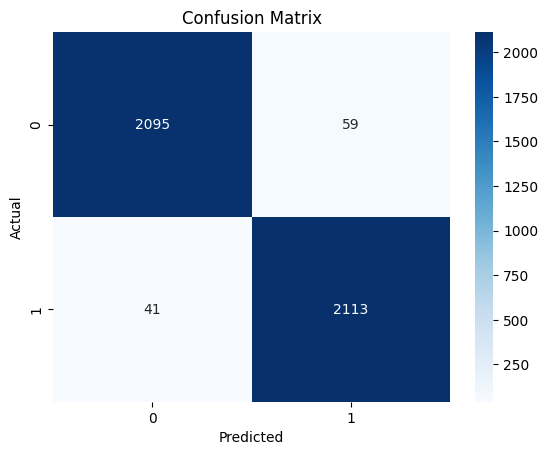

In [12]:
# === 혼동 행렬 시각화 ===
cm = confusion_matrix(y_sm, oof_preds_binary)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [13]:
# === 테스트 데이터 예측 및 저장 ===
test_preds_binary = (test_preds > 0.5).astype(int)
submission = pd.DataFrame({'ID': test_id, '허위매물여부': test_preds_binary})
submission.to_csv('submission_2.csv', index=False)
print("Submission file saved to 'submission_2.csv'")

Submission file saved to 'submission_2.csv'
